In [1]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
# diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa']].loc[~df['cid10_faixa'].isnull()]
# diagnosticos = diagnosticos.fillna('Sem')

diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [14]:
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  # X_train[i].unique().tolist()
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, "", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, "", diagnosticos[i].unique().tolist()))

In [43]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}' 
  
  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [ ]:
learner = gum.BNLearner(diagnosticos, bn)
bn1 = learner.learnParameters(bn.dag())
gnb.showInference(bn1, size="10")

In [16]:
learner = gum.BNLearner(diagnosticos, template)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@000001AF6FE277A0) BN{nodes: 14, arcs: 15, domainSize: 10^9.85975, dim: 512, mem: 4Ko 704o}

In [78]:
learner = gum.BNLearner(diagnosticos, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn3 = learner.learnBN()
bn3

(pyAgrum.BayesNet<double>@000001AF6FE32600) BN{nodes: 14, arcs: 17, domainSize: 10^9.85975, dim: 4734, mem: 40Ko 680o}

In [49]:
import pyAgrum.skbn as skbn

In [79]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn3,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")


Binary classifier : False


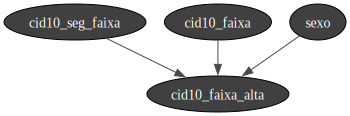

In [80]:
gnb.showBN(bnc.MarkovBlanket)

In [81]:
xTrain, yTrain = bnc.XYfromCSV(filename ='Diagnosticos.csv' )
print(f"predicted : {list(bnc.predict(xTrain))}")
print(f"in base   : {yTrain.to_list()}")

predicted : ['F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F30-F39', 'F30-F39', 'F60-F69', 'F10-F19', 'F10-F19', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F30-F39', 'F30-F39', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F70-F79', 'F20-F29', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F30-F39

In [54]:
diagnosticos.to_csv('Diagnosticos.csv', index=False)

In [82]:
scoreCSV1 = bnc.score('Diagnosticos.csv', y = yTrain)
print("{0:.2f}% good predictions".format(100*scoreCSV1))

73.59% good predictions


In [71]:
sum(x)

8218